In [1]:
%matplotlib inline

In [2]:
import glob, os, sys
import xarray
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from scipy.stats import circmean

In [4]:
from IPython.display import Image

In [5]:
from matplotlib.ticker import FormatStrFormatter

In [6]:
from matplotlib import gridspec

In [7]:
fs=18
plt.rc("font",size=fs)

In [8]:
# inpath = "/glade/scratch/doubrawa/post_processing/"
inpath = "/Volumes/Baby-Orange/XPIA-NCAR/rawest/"
proc_path = "/Volumes/Baby-Orange/XPIA-NCAR/processed/"
outpath = "/Volumes/Baby-Orange/XPIA-NCAR/processed/"

In [9]:
figpath = "../figs/"

In [10]:
days = [20,21,28,29,30]

### which times we are keeping? i.e. which ones are convective cell cases

In [11]:
convective      = pd.read_csv(os.path.join(proc_path,"datetimes_ziL_gt_25.csv"),header=None,index_col=[0])
convective_list = np.array([ pd.Timestamp(l[0]) for l in convective.values.tolist() ])

In [12]:
nt = len(convective_list)

In [13]:
nt

269

### what is our zi?

In [14]:
extent_of_interest_km = 15
zi_dict = {}
for day in days:
    infile = "PBLH_SPATIAL_AVG_{0:.0f}km_by_{0:.0f}km_D02_March{1}.csv".format(extent_of_interest_km,day)
    zi_dict[day] = pd.read_csv(os.path.join(proc_path,infile), index_col=0, parse_dates=True)

In [15]:
zis=pd.concat([zi_dict[20],zi_dict[21],zi_dict[28],zi_dict[29],zi_dict[30]]).sort_index()

### what is our zi/L?

In [16]:
zil = pd.read_csv(os.path.join(proc_path,"ziL_all_days.csv"), index_col=[0],header=None,parse_dates=True)

In [17]:
zil.head()

,1
0,
2015-03-20 14:00:00,196.476352
2015-03-20 14:10:00,82.087713
2015-03-20 14:20:00,116.894433
2015-03-20 14:30:00,120.092838
2015-03-20 14:40:00,157.882616


### what is our L?

In [18]:
days = [20,21,28,29,30]

Ls  = {}

for day in days:
    filename = glob.glob(os.path.join(proc_path,"L_SPATIAL*March{0}*".format(day)))[0]
    print(filename)
    L = pd.read_csv(filename,index_col=[0],parse_dates=True,header=None)
    Ls[day] = L.copy()

/Volumes/Baby-Orange/XPIA-NCAR/processed/L_SPATIAL_AVG_15km_by_15km_D02_March20.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/L_SPATIAL_AVG_15km_by_15km_D02_March21.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/L_SPATIAL_AVG_15km_by_15km_D02_March28.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/L_SPATIAL_AVG_15km_by_15km_D02_March29.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/L_SPATIAL_AVG_15km_by_15km_D02_March30.csv


In [19]:
Ls=pd.concat([Ls[20],Ls[21],Ls[28],Ls[29],Ls[30]]).sort_index()

### define some parameters for automated plotting

In [62]:
labels = {"ws":"Horizontal Wind Speed [m/s]",
          "ws_filt":"Horizontal Wind Speed [m/s]",
          "theta_filt":"Potential Temperature [K]",
          "tke":"Turbulent Kinetic Energy [m$^2$ s$^{{-2}}$]",
          "tke_filt":"Turbulent Kinetic Energy [m$^2$ s$^{{-2}}$]",
          "wT":"Kinematic Heat Flux [m s$^{{-1}}$ K]",
          "wT_filt":"Kinematic Heat Flux [m s$^{{-1}}$ K]",
          "w_filt":"Vertical velocity [m/s]",
          "wd_filt":"Wind direction [deg]",
          "ww_filt":"Vertical velocity variance [m$^2$ s$^{{-2}}$]",
          "Uw_filt":"Momentum flux [m$^2$ s$^{{-2}}$]"}

units = {"ws":"[m/s]",
          "ws_filt":"[m/s]",
          "theta_filt":"[K]",
          "tke":"[m$^2$ s$^{{-2}}$]",
          "tke_filt":"[m$^2$ s$^{{-2}}$]",
          "wT":"[m s$^{{-1}}$ K]",
          "wT_filt":"[m s$^{{-1}}$ K]",
          "w_filt":"[m/s]",
          "wd_filt":"[deg]",
          "ww_filt":"[m$^2$ s$^{{-2}}$]",
          "Uw_filt":"[m$^2$ s$^{{-2}}$]"}

xlims = {"ws":[0,5],
         "ws_filt":[0,5],
         "theta_filt":[300,310],
         "tke":[0,4],
         "tke_filt":[0,4],
         "wT":[],
         "wT_filt":[],
         "ww_filt":[],
         "Uw_filt":[]}

In [21]:
colors = { "LES":"k",
          "vles":"#808B96",
          "mynn":"#641E16",
           "ysu":"#A93226",
            "sh":"#D98880",}

lss    = { "LES":"-",
          "vles":"-",
          "mynn":"-.",
           "ysu":"--",
            "sh":":",}

### i/o

In [22]:
sims = ["LES","vles","mynn","ysu","sh"]

In [23]:
varnames = ["ws_filt","theta_filt","w_filt","tke_filt","wT_filt","wd_filt","ww_filt","Uw_filt"]#"ws","theta","w","tke","wT","wd"]

In [24]:
norms = {varname:pd.DataFrame(index=convective_list,columns=["vles","mynn","ysu","sh"]) for varname in varnames}
rmse  = {varname:pd.DataFrame(index=convective_list,columns=["vles","mynn","ysu","sh"]) for varname in varnames}

# funcs

In [25]:
def get_data_at_a_time(sim,datetime,include_not_filtered=False):

    filepath = glob.glob(os.path.join(inpath,"*_{0}_*{1:%Y-%m-%d_%H:%M}*plus_filtered.nc".format(sim,datetime)))[0]

    all_data = xarray.open_dataset(filepath)
    pts = gz_pts if sim!="LES" else les_pts        

    # sub-select a portion for planar averaging of these quantities
    all_data = all_data.isel(west_east=pts).isel(south_north=pts)

    all_data["ws_filt"] = np.sqrt(all_data["u_filt"]**2 + all_data["v_filt"]**2)
    all_data["wd_filt"] = 180.0 + np.degrees(np.arctan2(all_data["v_filt"],all_data["u_filt"]))            

    u_mean = all_data["u_filt"].mean(dim=["south_north","west_east"])
    v_mean = all_data["v_filt"].mean(dim=["south_north","west_east"])
    w_mean = all_data["w_filt"].mean(dim=["south_north","west_east"])
    T_mean = all_data["theta_filt"].mean(dim=["south_north","west_east"])
    U_mean = all_data["ws_filt"].mean(dim=["south_north","west_east"])

    u_prime = all_data["u_filt"] - u_mean
    v_prime = all_data["v_filt"] - v_mean
    w_prime = all_data["w_filt"] - w_mean
    T_prime = all_data["theta_filt"] - T_mean
    U_prime = all_data["ws_filt"] - U_mean
        
    u_prime_u_prime_mean = (u_prime**2).mean(dim=["south_north","west_east"])
    v_prime_v_prime_mean = (v_prime**2).mean(dim=["south_north","west_east"])
    w_prime_w_prime_mean = (w_prime**2).mean(dim=["south_north","west_east"])
    w_prime_T_prime_mean = (w_prime*T_prime).mean(dim=["south_north","west_east"])
    w_prime_U_prime_mean = (w_prime*U_prime).mean(dim=["south_north","west_east"])
    
    tke = 0.5 * (u_prime_u_prime_mean + v_prime_v_prime_mean + w_prime_w_prime_mean)

    all_data["tke_filt"]      = tke.copy()
    all_data["wT_filt"]       = w_prime_T_prime_mean.copy()  
    all_data["ww_filt"]  = w_prime_w_prime_mean.copy()
    all_data["Uw_filt"]  = w_prime_U_prime_mean.copy()   
        
    if include_not_filtered:

        all_data["ws"] = np.sqrt(all_data[sim]["u"]**2 + all_data[sim]["v"]**2)
        all_data["wd"] = 180.0 + np.degrees(np.arctan2(all_data[sim]["v"],all_data[sim]["u"]))

        u_mean = all_data["u"].mean(dim=["south_north","west_east"])
        v_mean = all_data["v"].mean(dim=["south_north","west_east"])
        w_mean = all_data["w"].mean(dim=["south_north","west_east"])
        T_mean = all_data["theta"].mean(dim=["south_north","west_east"])
        U_mean = all_data["ws"].mean(dim=["south_north","west_east"])

        u_prime = all_data["u"] - u_mean
        v_prime = all_data["v"] - v_mean
        w_prime = all_data["w"] - w_mean
        T_prime = all_data["theta"] - T_mean
        U_prime = all_data["ws"] - U_mean

        u_prime_u_prime_mean = (u_prime**2).mean(dim=["south_north","west_east"])
        v_prime_v_prime_mean = (v_prime**2).mean(dim=["south_north","west_east"])
        w_prime_w_prime_mean = (w_prime**2).mean(dim=["south_north","west_east"])
        w_prime_T_prime_mean = (w_prime*T_prime).mean(dim=["south_north","west_east"])
        w_prime_U_prime_mean = (w_prime*U_prime).mean(dim=["south_north","west_east"])

        tke = 0.5 * (u_prime_u_prime_mean + v_prime_v_prime_mean + w_prime_w_prime_mean)

        all_data["tke"] = tke.copy()
        all_data["wT"]  = w_prime_T_prime_mean.copy() 
        all_data["ww"]  = w_prime_w_prime_mean.copy()
        all_data["Uw"]  = w_prime_U_prime_mean.copy()    
    
    return all_data        

# get mean wind direction and wind speed profile from RLES 

In [26]:
# how much distance should we consider along x and y?
box_side = 15000 # 15 km

les_npts= int(box_side/25.0)
tot_pts = 1200
les_pt1 = int((tot_pts/2)-les_npts/2)
les_pt2 = les_pt1 + les_npts
les_pts = np.arange(les_pt1,les_pt2,1)
les_pts = [int(a) for a in les_pts]

# MUST FIX THESE
gz_npts = int(box_side/333.0)
tot_pts = 90
gz_pt1  = int((tot_pts/2)-int(gz_npts/2))
gz_pt2  = gz_pt1 + gz_npts
gz_pts  = np.arange(gz_pt1,gz_pt2,1)
# sim = "LES"
print("will consider RLES points between {0} and {1} ({2} pts)".format(les_pt1, les_pt2,len(les_pts)))
print("will consider VLES, YSU, SH, MYNN points between {0} and {1} ({2} pts)".format(gz_pt1, gz_pt2,len(gz_pts)))

will consider RLES points between 300 and 900 (600 pts)
will consider VLES, YSU, SH, MYNN points between 23 and 68 (45 pts)


### check whether we already saved wind speed and direction profiles before

In [27]:
sim = "LES"

fout = os.path.join(proc_path,"wd_xymean_profiles_RLES_{0}_pts_by_{0}_pts.nc".format(les_npts))
print(fout)
isfile = glob.glob(fout)
if len(isfile)!=0:
    wd_profiles = xarray.open_dataarray(fout)

already_had = False    
fout = os.path.join(proc_path,"ws_xymean_profiles_RLES_{0}_pts_by_{0}_pts.nc".format(les_npts))
print(fout)
isfile = glob.glob(fout)
if len(isfile)!=0:
    ws_profiles = xarray.open_dataarray(fout)
    already_had = True
    
if not(already_had):
    
    wd_xymean_profiles = []
    ws_xymean_profiles = []

    count = 0
    for datetime in convective_list:

        filepath = glob.glob(os.path.join(inpath,"*_{0}_*{1:%Y-%m-%d_%H:%M}*plus_filtered.nc".format(sim,datetime)))[0]
        sys.stdout.write('\r'+filepath)

        data = xarray.open_dataset(filepath)

        wd_filt = 180.0 + np.degrees(np.arctan2(data["v_filt"],data["u_filt"]))            
        ws_filt = np.sqrt(data["u_filt"]**2 + data["v_filt"]**2)     

        # keep only a portion of the domain for the xy averaging, instead of considering 30 km x 30 km
        wd_filt = wd_filt.isel(west_east=les_pts).isel(south_north=les_pts)    
        ws_filt = ws_filt.isel(west_east=les_pts).isel(south_north=les_pts)        

        kmeans = []
        for k in wd_filt.bottom_top.values:
            kmeans.append(np.degrees(circmean(np.radians(wd_filt.isel(bottom_top=k).values))))
        tmparr = xarray.DataArray(data=kmeans,coords=[wd_filt['bottom_top']],name='wd_filt')
        tmparr['datetime'] = datetime
        wd_xymean_profiles.append(tmparr)

        tmparr = ws_filt.mean(dim=["south_north","west_east"])  
        tmparr['datetime'] = datetime    
        ws_xymean_profiles.append(tmparr)

        count +=1

    wd_profiles = xarray.concat(wd_xymean_profiles,dim='datetime')
    ws_profiles = xarray.concat(ws_xymean_profiles,dim='datetime')
    
    # the above takes several minutes to run so save the output
    fout = os.path.join(inpath,"wd_xymean_profiles_RLES_{0}_pts_by_{0}_pts.nc".format(les_npts))
    print(fout)    
    wd_profiles.to_netcdf(fout)    
    
    fout = os.path.join(inpath,"ws_xymean_profiles_RLES_{0}_pts_by_{0}_pts.nc".format(les_npts))
    print(fout)
    ws_profiles.to_netcdf(fout)

/Volumes/Baby-Orange/XPIA-NCAR/processed/wd_xymean_profiles_RLES_600_pts_by_600_pts.nc
/Volumes/Baby-Orange/XPIA-NCAR/processed/ws_xymean_profiles_RLES_600_pts_by_600_pts.nc


# check whether we already have norms

In [28]:
for key in norms.keys():
    fout = os.path.join(outpath,"norms_{0}_{1}_pts_by_{1}_pts.csv".format(key,len(gz_pts)))    
    fout = glob.glob(fout)
    if len(fout)==1:
        norms[key] = pd.read_csv(fout[0], index_col=[0], parse_dates=True)
    fout = os.path.join(outpath,"rmse_{0}_{1}_pts_by_{1}_pts.csv".format(key,len(gz_pts)))
    fout = glob.glob(fout)
    if len(fout)==1:
        rmse[key] = pd.read_csv(fout[0], index_col=[0], parse_dates=True)

In [43]:
convective_list[215]

Timestamp('2015-03-30 14:00:00')

# read & process all data

In [44]:
include_not_filtered = False
ntimes               = 176
plot                 = False

if ~include_not_filtered:
    varnames = [a for a in varnames if 'filt' in a]

for datetime in convective_list[215:]:

    zi = zi_dict[datetime.day]["median"].loc[datetime]  
    sys.stdout.write('\r{0}'.format(datetime))
    
    all_data = {}
    
    for sim in sims:
        
        filepath = glob.glob(os.path.join(inpath,"*_{0}_*{1:%Y-%m-%d_%H:%M}*plus_filtered.nc".format(sim,datetime)))[0]
        all_data[sim] = get_data_at_a_time(sim,datetime)     

    ntimes +=1

    for varname in varnames:
        
        # data for refernce simulation, "LES" 
        sim = "LES"
        try:
            profile_ref = all_data[sim][varname].mean(dim=["south_north","west_east"])
        except:
            profile_ref = all_data[sim][varname]
        profile_z_ref   = all_data[sim]["z"].mean(dim=["south_north","west_east"])            
        profile_z_ref  /= zi        
        
        idx             = (np.round(profile_z_ref.data,1))<=1.2
        profile_ref     = profile_ref.data[idx]
        profile_z_ref   = profile_z_ref.data[idx]        

        if plot:
            fig = plt.figure(figsize=(4,6))
            ax  = fig.add_subplot(111)                
            ax.plot(profile_ref, profile_z_ref, '-', color=colors[sim], ls=lss[sim], label=sim.upper(), lw=3)
        
        for sim in ["vles","mynn","ysu","sh"]:
            try:
                profile_var = all_data[sim][varname].mean(dim=["south_north","west_east"])
            except:
                profile_var = all_data[sim][varname]
            profile_z   = all_data[sim]["z"].mean(dim=["south_north","west_east"])
            profile_z  /= zi

            #idx         = (np.round(profile_z.data,1))<=1.5
            profile_var = profile_var.data[idx]
            profile_z   = profile_z.data[idx]

            norms[varname].loc[datetime,sim] = np.linalg.norm(profile_ref - profile_var)/np.linalg.norm(profile_ref)
            rmse[varname].loc[datetime,sim]  = np.sqrt(np.mean((profile_ref - profile_var)**2))
            
            if plot:
                ax.plot(profile_var, profile_z, '-', color=colors[sim], ls=lss[sim], label=sim.upper(), lw=3)

        if plot:
            ax.set_ylim([0,1.])    
            ax.set_yticks([0,0.5,1,1])
            ax.set_ylabel("Distance from ground\n$z/z_i$ [-]")

            # ax.set_xlim(xlims[varname])
            ax.set_xlabel(labels[varname])

            ax.set_title("{0:%Y/%m/%d %H:%M} UTC".format(datetime),fontsize=fs,y=1.05)

            plt.legend(handlelength=3,bbox_to_anchor=(1,1))                

            fig.savefig("../figs/profiles_{0}_{1:%Y-%m-%d_%H-%M}.png".format(varname,datetime),
                       dpi=200, bbox_inches="tight")

            plt.close(fig)
            
# for key in norms.keys():
#     fout = os.path.join(outpath,"norms_{0}_{1}_pts_by_{1}_pts.csv".format(key,len(gz_pts)))    
#     norms[key].to_csv(fout)
#     print ("==> {0}".format(fout))            
    
#     fout = os.path.join(outpath,"rmse_{0}_{1}_pts_by_{1}_pts.csv".format(key,len(gz_pts)))
#     rmse[key].to_csv(fout)
#     print ("==> {0}".format(fout))                   

2015-03-30 22:50:00

# plot a profile

In [49]:
varname = 'ws_filt'

max_error    = rmse[varname][norms[varname]==norms[varname].max().max()].dropna(how='all')
datetime_max = pd.Timestamp(max_error.index[0])

min_error    = rmse[varname][norms[varname]==norms[varname].min().min()].dropna(how='all')
datetime_min = pd.Timestamp(min_error.index[0])

In [50]:
max_error

,vles,mynn,ysu,sh
2015-03-20 18:50:00,1.397327,NaN,NaN,NaN


In [51]:
min_error

,vles,mynn,ysu,sh
2015-03-28 20:00:00,NaN,NaN,0.261044,NaN


In [68]:
datetime = datetime_max
print(datetime)

data_sims = {}

for sim in sims:

    data_sims[sim] = get_data_at_a_time(sim,datetime)    

2015-03-20 18:50:00


## just the panels without rmse bars

In [34]:
# fig = plt.figure(figsize=(4*5,8))
# axs = {}

# for iax,varname in enumerate(vars_to_plot):
    
#     axs[iax] = fig.add_subplot(1,4,iax+1)
#     axs[iax].grid(color='gray',linestyle=':',lw=1)

#     for sim in sims:

#         try:
#             profile_var = data_sims[sim][varname].mean(dim=["south_north","west_east"])
#         except:
#             profile_var = data_sims[sim][varname]
#         profile_z   = data_sims[sim]["z"].mean(dim=["south_north","west_east"])
#         zi          = zi_dict[datetime.day]["median"].loc[datetime]    
#         profile_z  /= zi

#         axs[iax].plot(profile_var, profile_z, color=colors[sim], label=sim, ls=lss[sim], lw=2)

#     axs[iax].set_xlabel(labels[varname])#,y=1.01)
#     axs[iax].set_ylim([0,1.1])

#     if iax>0:
#         plt.setp(axs[iax].get_yticklabels(), visible=False) 
        
#     axs[iax].xaxis.set_tick_params(direction='in')
#     axs[iax].yaxis.set_tick_params(direction='in')           
    
# axs[0].set_ylabel("Height above ground $z/z_i$ [-]")
        
# plt.legend(loc='best')

# fig.subplots_adjust(wspace=0.05)
# fig.suptitle("{0}".format(datetime))


# panels and rmse bars too

In [64]:
vars_to_plot = ['ws_filt','wd_filt','w_filt','theta_filt','ww_filt','Uw_filt','wT_filt','tke_filt']

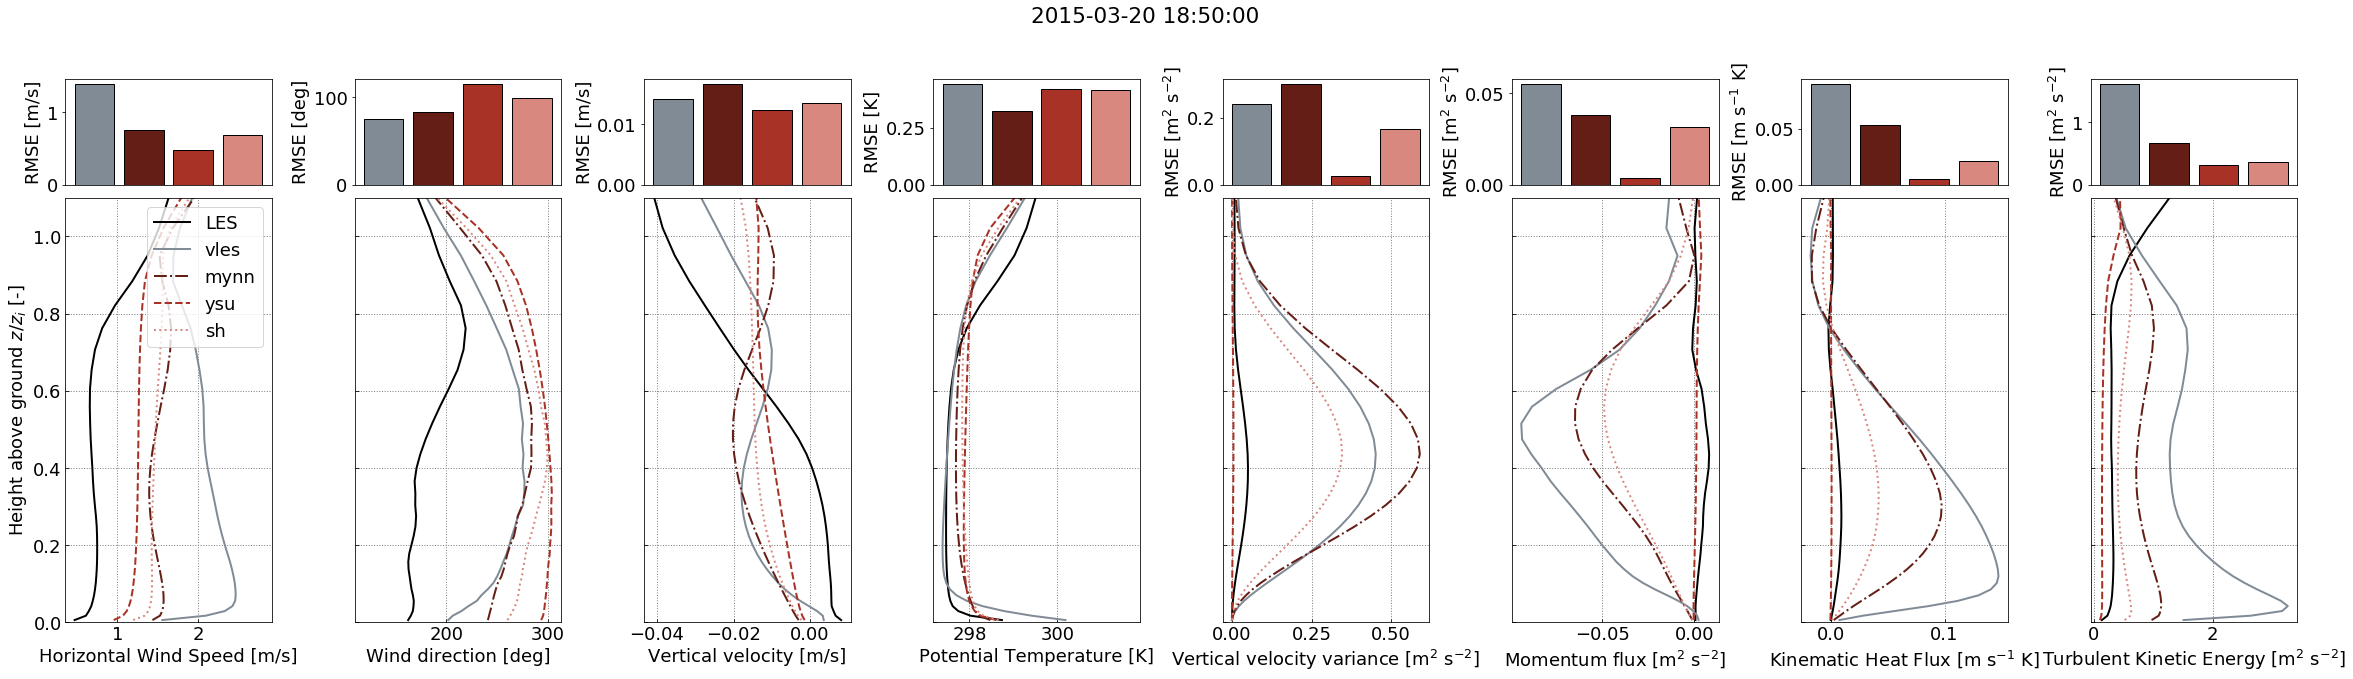

In [69]:
gs = gridspec.GridSpec(2, len(vars_to_plot), height_ratios=[1,4]) 

fig = plt.figure(figsize=(5*len(vars_to_plot),10))
axs = {}

for iax,varname in enumerate(vars_to_plot):
    axs[iax] = fig.add_subplot(gs[iax])
    for isim,sim in enumerate(sims):
        if sim!="LES":
            axs[iax].bar(x=isim,height=rmse[varname].loc[datetime,sim], fc=colors[sim],
                        ec='k')   
    plt.setp(axs[iax].get_xticklabels(), visible=False) 
    axs[iax].tick_params(bottom=False)#
    axs[iax].set_ylabel("RMSE {0}".format(units[varname]))    
    #axs[iax].yaxis.set_major_formatter(FormatStrFormatter('%5.2f'))    
    #axs[iax].set_ylim([0,1.8])
    
for iax,varname in enumerate(vars_to_plot):
    
    iax += len(vars_to_plot)
    
    axs[iax] = fig.add_subplot(gs[iax])
    axs[iax].grid(color='gray',linestyle=':',lw=1)

    for sim in sims:

        try:
            profile_var = data_sims[sim][varname].mean(dim=["south_north","west_east"])
        except:
            profile_var = data_sims[sim][varname]
        profile_z   = data_sims[sim]["z"].mean(dim=["south_north","west_east"])
        zi          = zi_dict[datetime.day]["median"].loc[datetime]    
        profile_z  /= zi

        axs[iax].plot(profile_var, profile_z, color=colors[sim], label=sim, ls=lss[sim], lw=2)

    axs[iax].set_xlabel(labels[varname])#,y=1.01)
    axs[iax].set_ylim([0,1.1])

    if iax > len(vars_to_plot):
        plt.setp(axs[iax].get_yticklabels(), visible=False) 
        
    axs[iax].xaxis.set_tick_params(direction='in')
    axs[iax].yaxis.set_tick_params(direction='in')           
    
    if iax==len(vars_to_plot):
        plt.legend(loc='best')
    
axs[len(vars_to_plot)].set_ylabel("Height above ground $z/z_i$ [-]")
        
fig.subplots_adjust(wspace=0.4,hspace=0.05)
fig.suptitle("{0}".format(datetime))

fig.savefig(os.path.join(figpath,"profiles_and_rmse_{0:%Y-%m-%d_%H-%M}.png".format(datetime)),
           dpi=300,bbox_inches="tight")

# quick check : error norm as a function of zi/L

In [ ]:
for errortype,errordict in zip(["rmse","norms"],[rmse,norms]):
        
    fig = plt.figure(figsize=(len(vars_to_plot)*5,4))

    axbig = fig.add_subplot(111)
    axbig.spines['top'].set_color('none')
    axbig.spines['bottom'].set_color('none')
    axbig.spines['left'].set_color('none')
    axbig.spines['right'].set_color('none')
    axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)#     axbig.set_xlabel("$y_{rotor} - \Delta y_{wake}$",labelpad=-5)
    axbig.set_xlabel("$z_i/L$ [-]")

    axs = {}

    for iax,var in enumerate(vars_to_plot):

        ylab = "RMSE {0}".format(units[var]) if errortype=="rmse" else "Error Norm [-]"        
        
        axs[iax]  = fig.add_subplot(1,len(vars_to_plot),iax+1)
        axs[iax].grid(color='gray',linestyle=':',axis='both')

        tmp = errordict[var].copy()
        tmp["zil"] = zil.copy().round()
        means = tmp.astype("float").groupby(tmp.zil).mean()

        maxerr = 0
        for sim in ["vles","mynn","ysu","sh"]:
            axs[iax].scatter(tmp.zil, tmp[sim], color=colors[sim], label=sim, edgecolors='k', lw=0.5, alpha=0.5)
            maxerr = max(maxerr, tmp[sim].max())
        
        axs[iax].set_ylabel(ylab)        
        axs[iax].set_title(labels[var].split('[')[0])
        axs[iax].set_ylim([0,maxerr])

    fig.subplots_adjust(wspace=0.4,hspace=0.05)
    plt.legend(loc='best')    
    fig.savefig(os.path.join(figpath,"{0}_allvars_as_func_ziL.png".format(errortype)),dpi=300,bbox_inches="tight")

# quick check : error norm as a function of 1/L

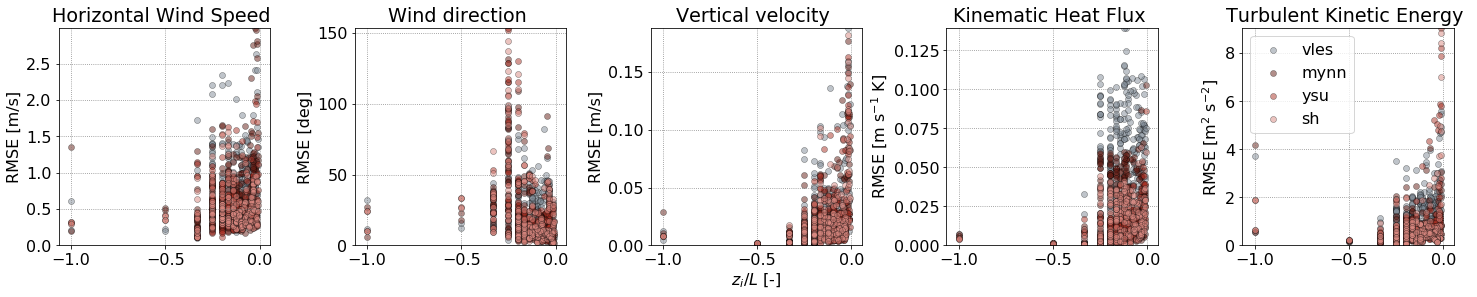

In [261]:
for errortype,errordict in zip(["rmse","norms"],[rmse,norms]):
        
    fig = plt.figure(figsize=(len(vars_to_plot)*5,4))

    axbig = fig.add_subplot(111)
    axbig.spines['top'].set_color('none')
    axbig.spines['bottom'].set_color('none')
    axbig.spines['left'].set_color('none')
    axbig.spines['right'].set_color('none')
    axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)#     axbig.set_xlabel("$y_{rotor} - \Delta y_{wake}$",labelpad=-5)
    axbig.set_xlabel("$z_i/L$ [-]")

    axs = {}

    for iax,var in enumerate(vars_to_plot):

        ylab = "RMSE {0}".format(units[var]) if errortype=="rmse" else "Error Norm [-]"        
        
        axs[iax]  = fig.add_subplot(1,len(vars_to_plot),iax+1)
        axs[iax].grid(color='gray',linestyle=':',axis='both')

        tmp = errordict[var].copy()
        tmp["L"] = Ls.copy().round()

        maxerr = 0
        for sim in ["vles","mynn","ysu","sh"]:
            axs[iax].scatter(1/tmp.L, tmp[sim], color=colors[sim], label=sim, edgecolors='k', lw=0.5, alpha=0.5)
            maxerr = max(maxerr, tmp[sim].max())
        
        axs[iax].set_ylabel(ylab)        
        axs[iax].set_title(labels[var].split('[')[0])
        axs[iax].set_ylim([0,maxerr])

    fig.subplots_adjust(wspace=0.4,hspace=0.05)
    plt.legend(loc='best')    
    break
    #     fig.savefig(os.path.join(figpath,"{0}_allvars_as_func_ziL.png".format(errortype)),dpi=300,bbox_inches="tight")


# quick check : error norm as a function of ws

In [185]:
ws_ts = ws_profiles.isel(bottom_top=np.arange(2,9,1)).mean(dim='bottom_top')
ws_ts = pd.Series(index=ws_ts.datetime,data=ws_ts.values)

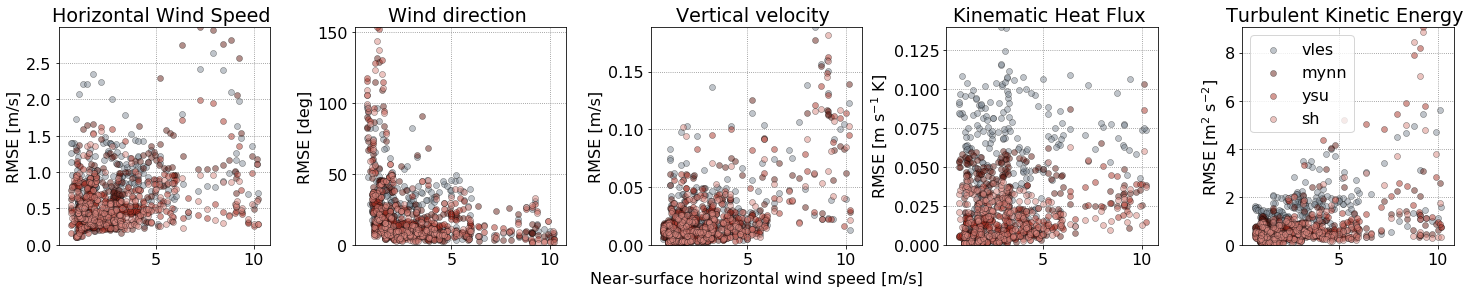

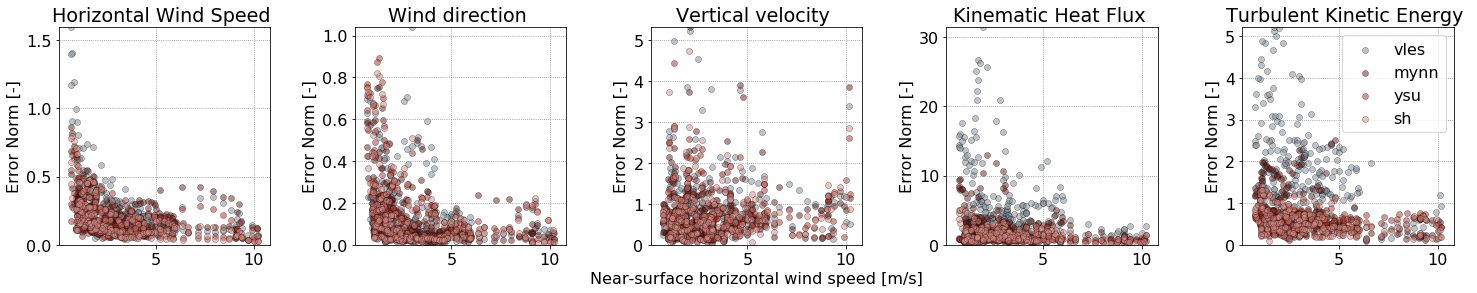

In [253]:
for errortype,errordict in zip(["rmse","norms"],[rmse,norms]):
        
    fig = plt.figure(figsize=(len(vars_to_plot)*5,4))

    axbig = fig.add_subplot(111)
    axbig.spines['top'].set_color('none')
    axbig.spines['bottom'].set_color('none')
    axbig.spines['left'].set_color('none')
    axbig.spines['right'].set_color('none')
    axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)#     axbig.set_xlabel("$y_{rotor} - \Delta y_{wake}$",labelpad=-5)
    axbig.set_xlabel("Near-surface horizontal wind speed [m/s]")

    axs = {}

    for iax,var in enumerate(vars_to_plot):

        ylab = "RMSE {0}".format(units[var]) if errortype=="rmse" else "Error Norm [-]"        
        
        axs[iax]  = fig.add_subplot(1,len(vars_to_plot),iax+1)
        axs[iax].grid(color='gray',linestyle=':',axis='both')

        tmp = errordict[var].copy()
        tmp["ws"]=ws_ts.copy()

        maxerr = 0
        for sim in ["vles","mynn","ysu","sh"]:
            axs[iax].scatter(tmp.ws, tmp[sim], color=colors[sim], label=sim, edgecolors='k', lw=0.5, alpha=0.5)
            maxerr = max(maxerr, tmp[sim].max())

        axs[iax].set_ylabel(ylab)    
        axs[iax].set_title(labels[var].split('[')[0])
        axs[iax].set_ylim([0,maxerr])

    fig.subplots_adjust(wspace=0.4,hspace=0.05)
    plt.legend(loc='best')    
    fig.savefig(os.path.join(figpath,"{0}_allvars_as_func_wspd.png".format(errortype)),dpi=300,bbox_inches="tight")    

# quick check : error norm as a function of wd

In [197]:
wd_ts = wd_profiles.isel(bottom_top=np.arange(8,9,1))

In [198]:
wd_zmeans = {}
for it in range(269):
    datetime=wd_ts.datetime[it].values
    wd_zmean=np.degrees(circmean(np.radians(wd_ts.isel(datetime=it))))
    wd_zmeans[datetime]=wd_zmean

In [199]:
wd_ts = pd.Series(wd_zmeans)

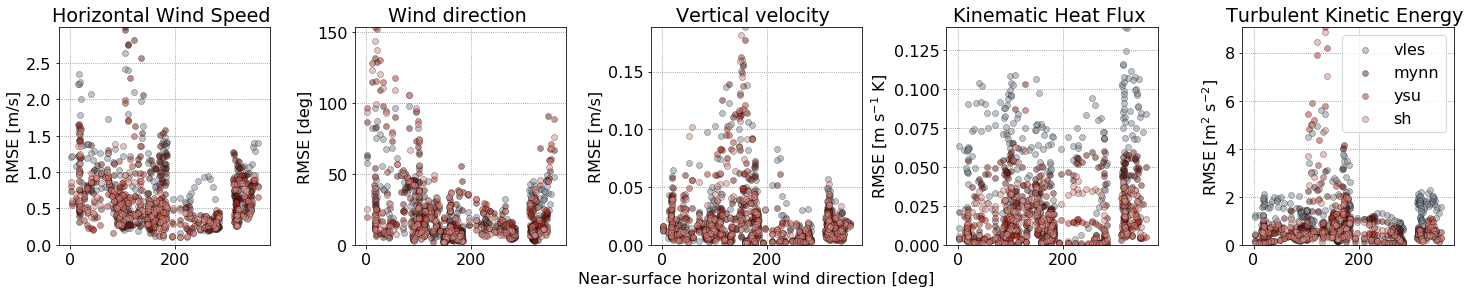

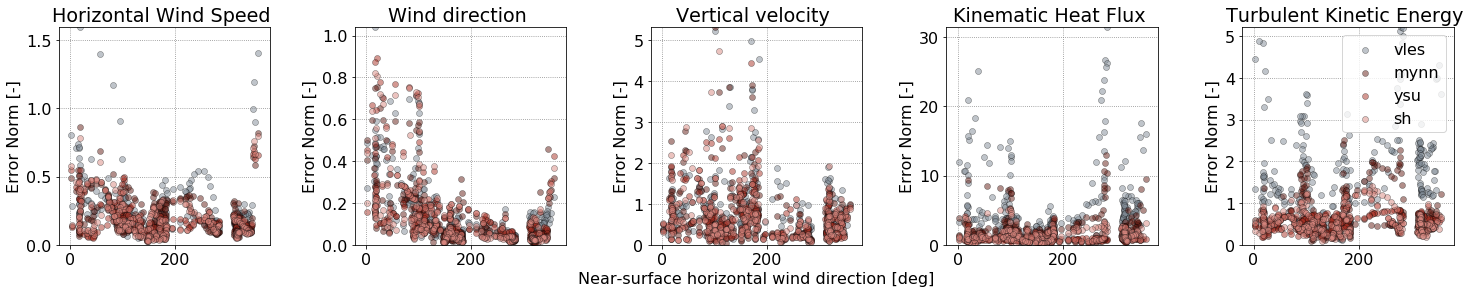

In [252]:
for errortype,errordict in zip(["rmse","norms"],[rmse,norms]):
        
    fig = plt.figure(figsize=(len(vars_to_plot)*5,4))

    axbig = fig.add_subplot(111)
    axbig.spines['top'].set_color('none')
    axbig.spines['bottom'].set_color('none')
    axbig.spines['left'].set_color('none')
    axbig.spines['right'].set_color('none')
    axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)#     axbig.set_xlabel("$y_{rotor} - \Delta y_{wake}$",labelpad=-5)
    axbig.set_xlabel("Near-surface horizontal wind direction [deg]")

    axs = {}

    for iax,var in enumerate(vars_to_plot):

        ylab = "RMSE {0}".format(units[var]) if errortype=="rmse" else "Error Norm [-]"        
        
        axs[iax]  = fig.add_subplot(1,len(vars_to_plot),iax+1)
        axs[iax].grid(color='gray',linestyle=':',axis='both')

        tmp = errordict[var].copy()
        tmp["wd"]=wd_ts.copy()

        maxerr = 0
        for sim in ["vles","mynn","ysu","sh"]:
            axs[iax].scatter(tmp.wd, tmp[sim], color=colors[sim], label=sim, edgecolors='k', lw=0.5, alpha=0.5)
            maxerr = max(maxerr, tmp[sim].max())

        axs[iax].set_ylabel(ylab)    
        axs[iax].set_title(labels[var].split('[')[0])
        axs[iax].set_ylim([0,maxerr])

    fig.subplots_adjust(wspace=0.4,hspace=0.05)
    plt.legend(loc='best')    
    fig.savefig(os.path.join(figpath,"{0}_allvars_as_func_wdir.png".format(errortype)),dpi=300,bbox_inches="tight")    

# quick check : error norm as a function of L

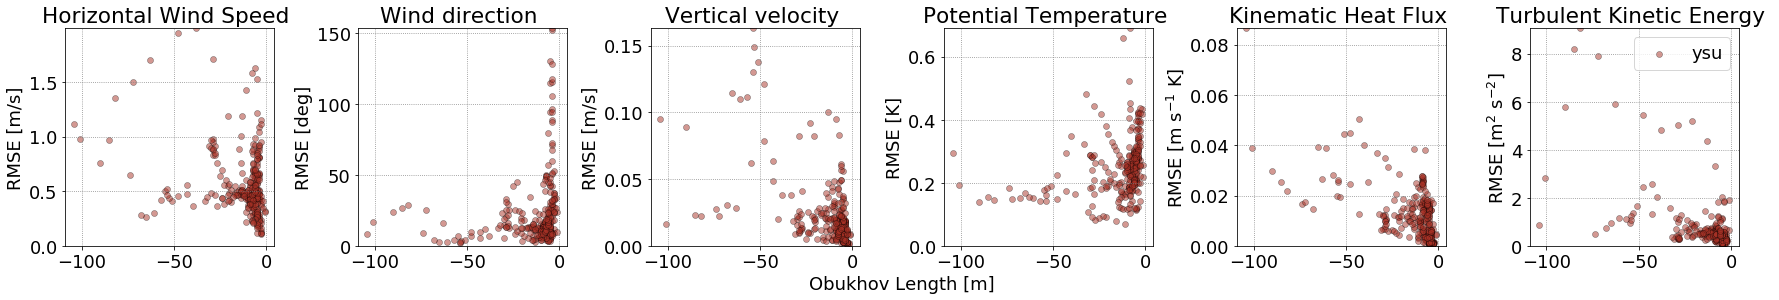

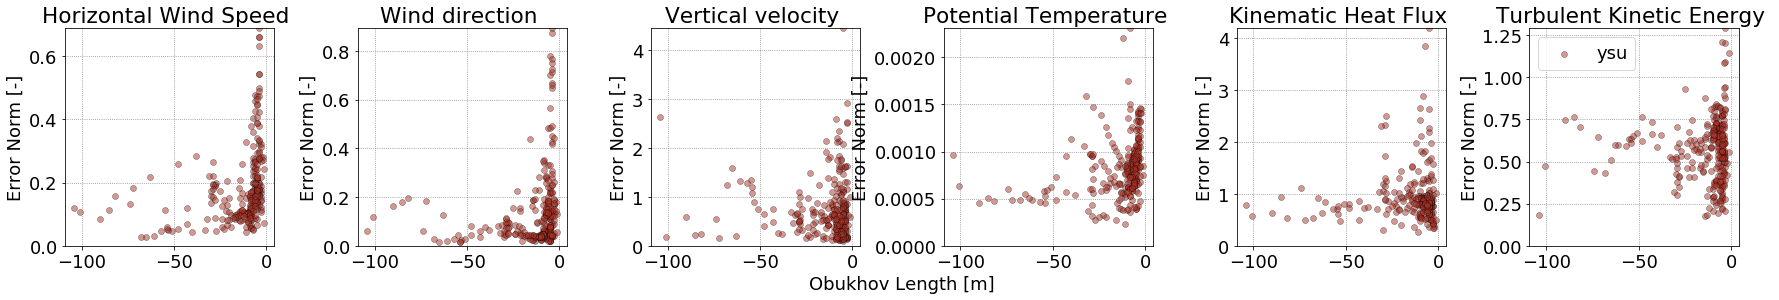

In [38]:
for errortype,errordict in zip(["rmse","norms"],[rmse,norms]):
    
    fig = plt.figure(figsize=(len(vars_to_plot)*5,4))

    axbig = fig.add_subplot(111)
    axbig.spines['top'].set_color('none')
    axbig.spines['bottom'].set_color('none')
    axbig.spines['left'].set_color('none')
    axbig.spines['right'].set_color('none')
    axbig.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)#     axbig.set_xlabel("$y_{rotor} - \Delta y_{wake}$",labelpad=-5)
    axbig.set_xlabel("Obukhov Length [m]")

    axs = {}

    for iax,var in enumerate(vars_to_plot):

        ylab = "RMSE {0}".format(units[var]) if errortype=="rmse" else "Error Norm [-]"        
    
        axs[iax]  = fig.add_subplot(1,len(vars_to_plot),iax+1)
        axs[iax].grid(color='gray',linestyle=':',axis='both')

        tmp = errordict[var].copy()
        tmp["L"]=Ls.copy().round()

        maxerr = 0
        for sim in ["ysu"]:#,"mynn","ysu","sh"]:
            axs[iax].scatter(tmp.L, tmp[sim], color=colors[sim], label=sim, edgecolors='k', lw=0.5, alpha=0.5)
            maxerr = max(maxerr, tmp[sim].max())

        axs[iax].set_ylabel(ylab)    
        axs[iax].set_title(labels[var].split('[')[0])
        axs[iax].set_ylim([0,maxerr])

    fig.subplots_adjust(wspace=0.4,hspace=0.05)
    plt.legend(loc='best')    
    #fig.savefig(os.path.join(figpath,"{0}_allvars_as_func_L.png".format(errortype)),dpi=300,bbox_inches="tight")    

## categorize error according to obukhov length value

In [140]:
len(tmp[((tmp.L<0) & (tmp.L>=-50))])

252

In [137]:
var= 'ws_filt'

tmp        = errordict[var].copy()
tmp["L"]   = Ls.copy().round()
means      = tmp.astype("float").groupby(tmp.L).mean()    
tmp['cat'] = 0


In [141]:
    lowlim = 0
    labs = {}
    for lim in lims:
        idx = ((tmp.L<lowlim  )&(tmp.L>=lim))
        tmp.loc[idx,'cat'] = lim
        labs[lim] = "[{1},{0})".format(lowlim,lim)
        npts = len(idx[idx])        
        print("L < {0} & L >= {1} : {2} pts".format(lowlim,lim,npts))        
        lowlim = lim 
        

L < 0 & L >= -50 : 252 pts
L < -50 & L >= -100 : 15 pts
L < -100 & L >= -200 : 2 pts


array([ -10.,  -20.,  -30.,  -40.,  -50.,  -60.,  -70.,  -80.,  -90.,
       -100., -150.])

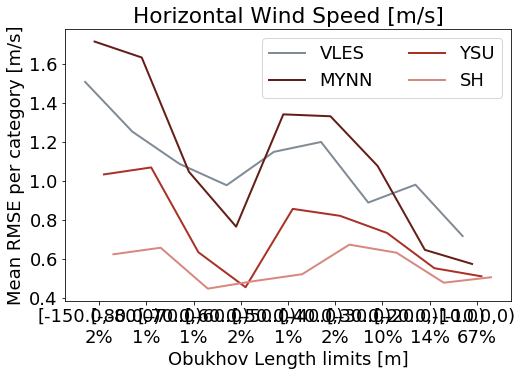

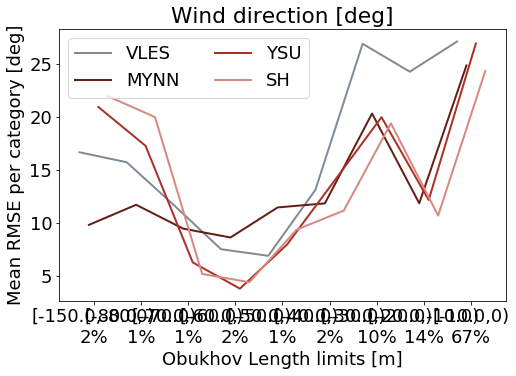

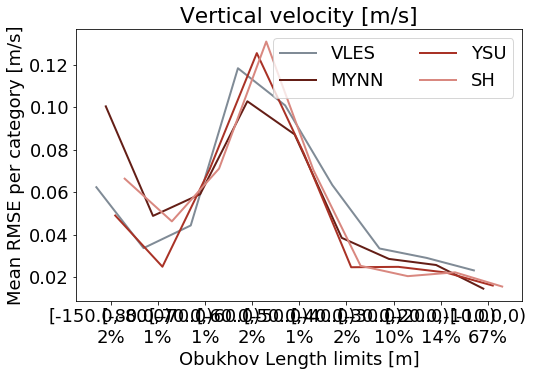

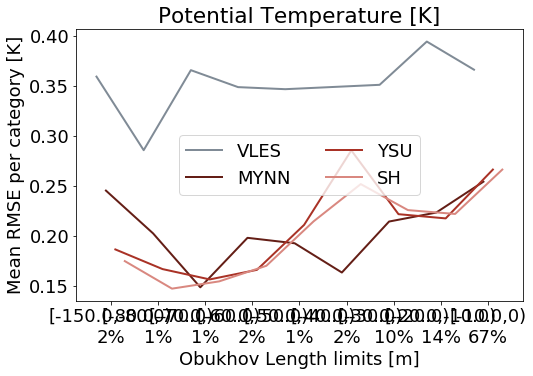

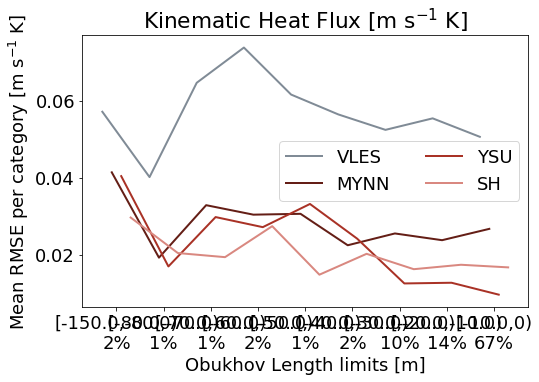

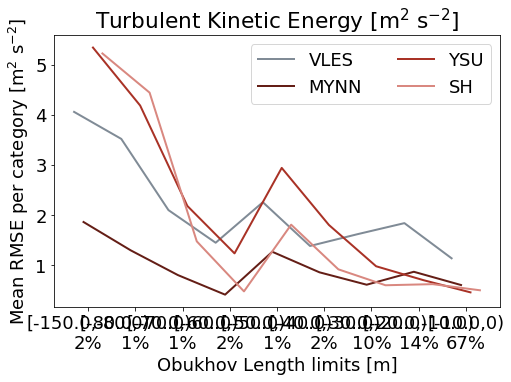

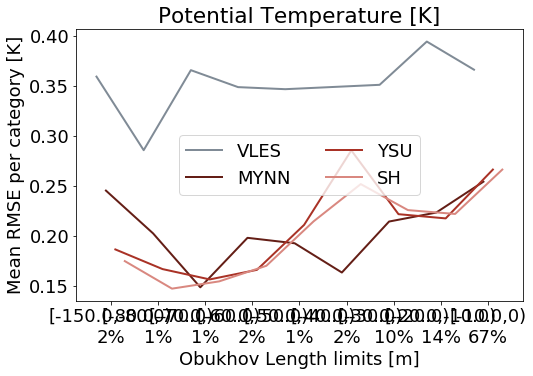

In [67]:
errortype = 'rmse'
errordict = rmse
lims      = np.arange(-10, -80.1, -10)#[-10,-40,-200]
lims      = np.append(lims,-150)

for var in vars_to_plot+["theta_filt"]:

    tmp        = errordict[var].copy()
    tmp["L"]   = Ls.copy().round()
    means      = tmp.astype("float").groupby(tmp.L).mean()    
    tmp['cat'] = 0

    lowlim = 0
    labs = {}
    perct = {}
    for lim in lims:
        idx = ((tmp.L<lowlim  )&(tmp.L>=lim))
        tmp.loc[idx,'cat'] = lim
        labs[lim] = "[{1},{0})".format(lowlim,lim)
        npts = len(idx[idx])  
        perct[lim] = (npts/float(len(tmp)))*100
        #print("L < {0} & L >= {1} : {2} pts".format(lowlim,lim,npts))        
        lowlim = lim 
        
    means = tmp.astype("float").groupby(tmp.cat).mean()        
    stds  = tmp.astype("float").groupby(tmp.cat).std()        
    
    fig = plt.figure(figsize=(8,5))
    ax  = fig.add_subplot(111)
    #ax.grid(color='gray',linestyle=':',axis='both')

    labs_list = []
    width = 0.2
    
    for sim_offset,sim in zip([-width*2,-width*1,0,width],["vles","mynn","ysu","sh"]):
        
        #ax.plot(tmp.L.values, tmp[sim].values,'o',color=colors[sim], mec='k', alpha=0.5, ms=8)
        
        if sim=="vles":
            for iii,lim in enumerate(means.index): 
                labs_list.append(labs[lim]+'\n'+'{0:.0f}%'.format(perct[lim]))        

        # ERRORBAR -- LOOKS BAD        
        # ax.errorbar(range(len(lims)), means[sim].values, yerr=stds[sim].values, color=colors[sim], 
        #       marker='s', mec='k', alpha=1, elinewidth=2, capsize=10)
        
        # BARS -- HARD TO PICK OUT TRENDS
        # ixs = np.asarray(np.arange(0,len(lims),1))
        #ax.bar(ixs+width/2+sim_offset, means[sim].values, color=colors[sim], width=width,
        #       alpha=1,align='center',ec='k', label=sim.upper())        
        
        ax.plot(ixs+width/2+sim_offset, means[sim].values, color=colors[sim], 
              alpha=1,lw=2,label=sim.upper())        

    ax.set_xticks(range(len(means.index)))
    ax.set_xticklabels(labs_list)

    ax.set_title(labels[var])
    ax.set_xlabel("Obukhov Length limits [m]")
    ax.set_ylabel("Mean RMSE per category {0}".format(units[var]))
    
    plt.legend(loc='best',ncol=2)

#     fig.savefig(os.path.join(figpath,"mean_rmse_by_L_category_{0}.png".format(var)),dpi=300,bbox_inches="tight")    

## categorize error according to wind speed value

# profile error norms by time of day

In [71]:
errordict = rmse

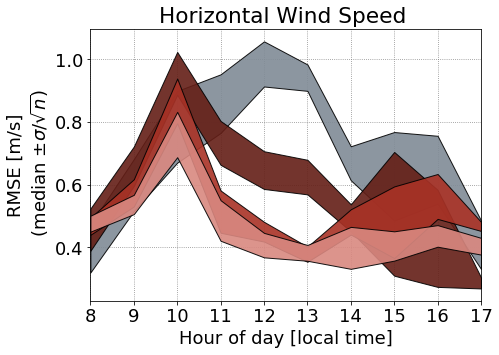

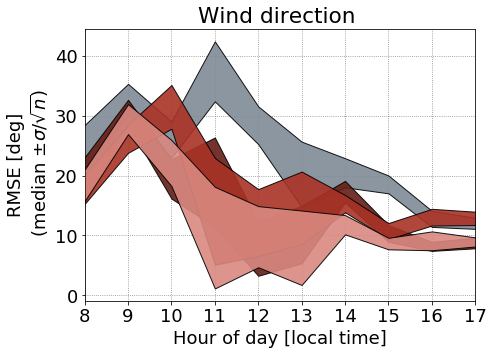

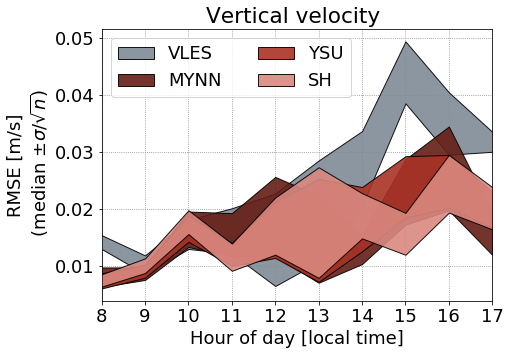

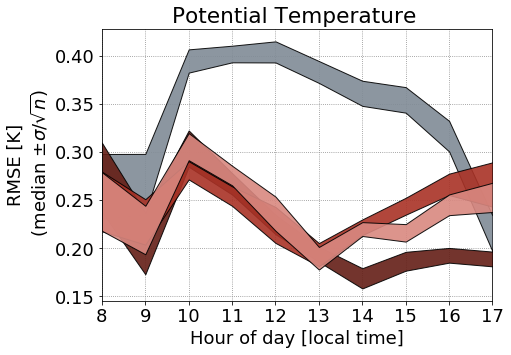

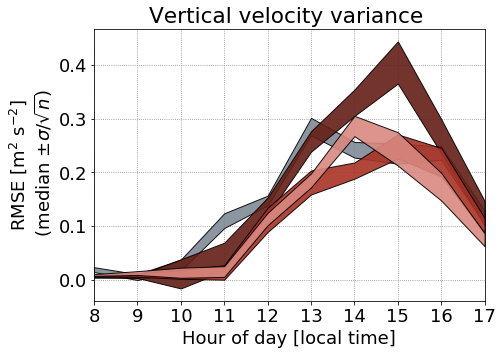

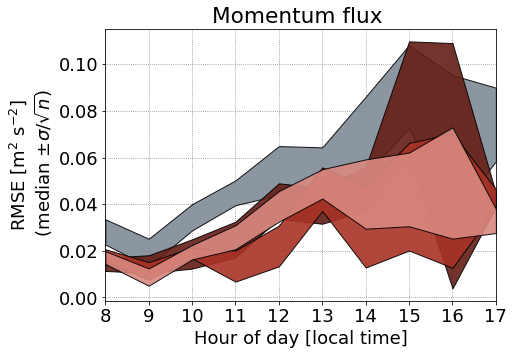

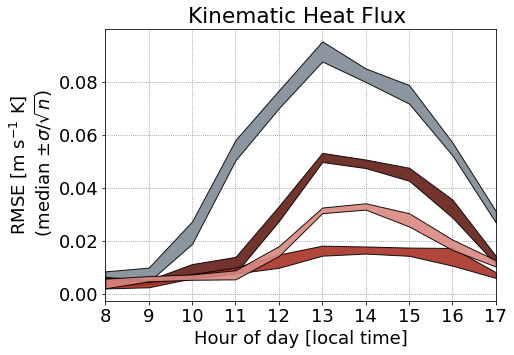

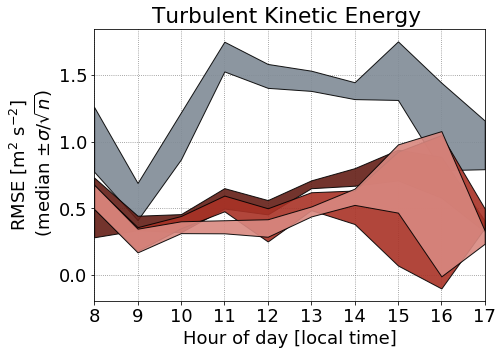

In [72]:
for var in vars_to_plot:

    hourly_means   = errordict[var].astype("float").groupby(norms[var].index.hour).mean()
    hourly_medians = errordict[var].astype("float").groupby(norms[var].index.hour).median()
    hourly_count   = errordict[var].astype("float").groupby(norms[var].index.hour).count()
    hourly_std     = errordict[var].astype("float").groupby(norms[var].index.hour).std()

    fig = plt.figure(figsize=(7,5))
    ax  = fig.add_subplot(111)
    ax.grid(color='gray',linestyle=':',axis='both')

    for isim,sim in enumerate(hourly_means.columns):
        #         ax.plot(hourly_medians[sim].index,
        #                     hourly_medians[sim].values,
        #                     color=colors[sim], label=sim, ls=lss[sim], lw=3, marker=None,
        #                mec='k',mew=0.5,alpha=0.8)

        stdnorm = hourly_std[sim].values/np.sqrt(hourly_count[sim])
        ax.fill_between(hourly_medians[sim].index, hourly_medians[sim].values-stdnorm,
                           hourly_medians[sim].values+stdnorm, facecolor=colors[sim], edgecolor='k',
                       alpha=0.9,zorder=20.0,label=sim.upper())
    #     ax.errorbar(x=hourly_means[sim].index+isim*0.1,
    #                 y=hourly_means[sim].values,
    #                 yerr=hourly_std[sim].values, color=colors[sim], label=sim, ls=lss[sim], lw=3, marker='o')

    if var=="w_filt":
        plt.legend(loc=2,ncol=2)

    xticks = np.arange(14,24,1)
    ax.set_xlim([8+6,17+6])
    ax.set_xticks(xticks)
    ax.set_xticklabels(["{}".format(ii-6) for ii in xticks])
    ax.set_xlabel("Hour of day [local time]")
    ax.set_ylabel("RMSE {0}".format(units[var])+"\n (median $\pm \sigma/\sqrt{n}$)")
    ax.set_title(labels[var].split('[')[0])

    fig.savefig(os.path.join(figpath,"median_rmse_by_hour_{0}.png".format(var)),dpi=300,bbox_inches="tight")    

# plot

get outliers

top_points = r["fliers"][0].get_data()[1]
bottom_points = r["fliers"][2].get_data()[1]

where r is plot object


or

bp['medians'][0].get_ydata()

In [89]:
allprops = {'linewidth':2,'color':'k'}

vles
mynn
ysu
sh
vles
mynn
ysu
sh
vles
mynn
ysu
sh
vles
mynn
ysu
sh
vles
mynn
ysu
sh
vles
mynn
ysu
sh
vles
mynn
ysu
sh
vles
mynn
ysu
sh
vles
mynn
ysu
sh


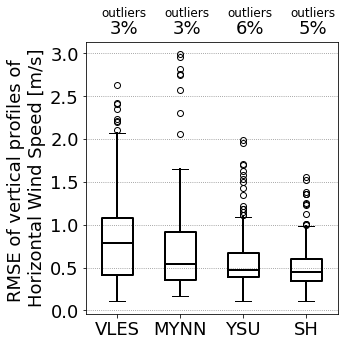

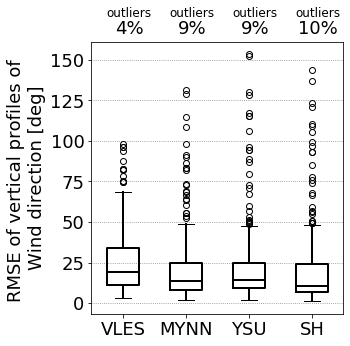

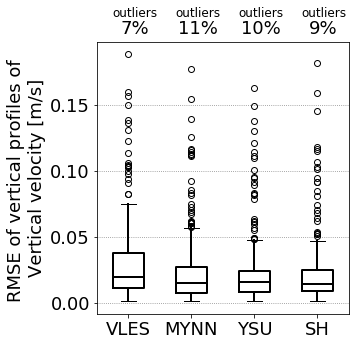

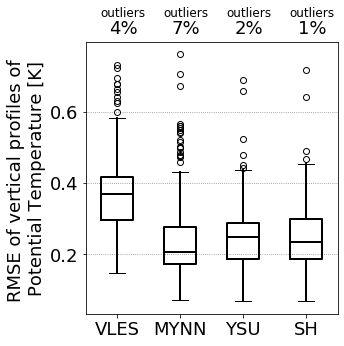

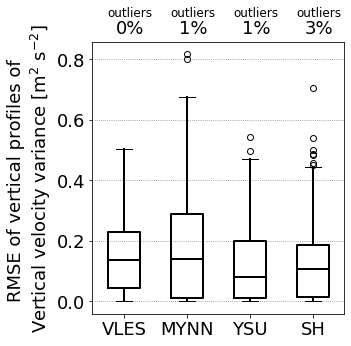

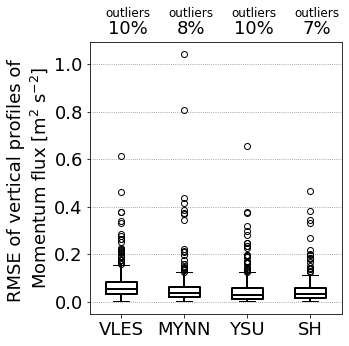

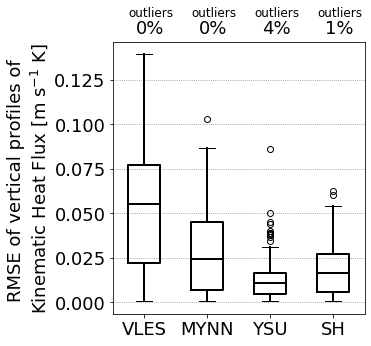

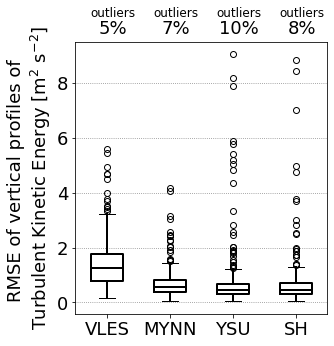

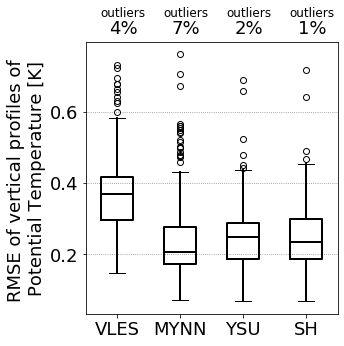

In [97]:
# for errortype,errordict in zip(["rmse","norms"],[rmse,norms]):

errortype="rmse"
errordict=rmse

for varname in vars_to_plot+["theta_filt"]:

    dflink    = errordict[varname].astype('float').copy()

    fig = plt.figure(figsize=(7,5))
    ax  = fig.add_subplot(111)

    ax.grid(color='gray',linestyle=':',axis='y')

    xticks = []
    xticklabs = []

    i=0
    for sim in dflink.keys():
        print(sim)
        i+=1    

        p = ax.boxplot(dflink[sim].values, positions=[i],widths=[0.5],
                  boxprops=allprops,
                  medianprops=allprops,
                  whiskerprops=allprops)    
        xticks.append(i)
        xticklabs.append(sim.upper())
        
        outlier_percent = np.round((float(len(p['fliers'][0].get_ydata()))/float(len(dflink[sim].values)))*100)

        ax.text(0.15+(i-1)*0.25, 1.105, 'outliers', fontsize=12, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)                
        ax.text(0.15+(i-1)*0.25, 1.05, '{0:.0f}%'.format(outlier_percent), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)        
        

    ax.set_xlim([0.5,4.5])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)

    errortypelab = 'RMSE' if errortype=='rmse' else 'Error norm'
    varlab = labels[varname] if errortype=='rmse' else labels[varname].split('[')[0]
    ax.set_ylabel('{1} of vertical profiles of \n{0}'.format(varlab,errortypelab))

    fig.subplots_adjust(left=0.4)
    
    fig.savefig(os.path.join(figpath,"{0}_{1}_whiskers.png".format(errortype,varname)),
              dpi=250,bbox_inches="tight")

5.0

In [111]:
(48+64)/2.

56.0

In [112]:
(12+23)/2.


17.5